In [31]:
# Final Script to create plots to put into the documentation.

import os
import uuid
import zipfile
from os.path import join, dirname
from tempfile import gettempdir
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

from aequilibrae import TrafficAssignment, TrafficClass, Graph, Project, ODME
from tests.data import siouxfalls_project

import warnings
warnings.filterwarnings('ignore')

In [32]:
os.environ["PATH"] = os.path.join(gettempdir(), "temp_data") + ";" + os.environ["PATH"]
proj_path = os.path.join(gettempdir(), "test_odme_files" + uuid.uuid4().hex)
os.mkdir(proj_path)
zipfile.ZipFile(join(dirname(siouxfalls_project), "sioux_falls_single_class.zip")).extractall(proj_path)

project = Project()
project.open(proj_path)
project.network.build_graphs()
car_graph = project.network.graphs["c"]  # type: Graph

car_graph.set_graph("free_flow_time")
car_graph.set_blocked_centroid_flows(False)
matrix = project.matrices.get_matrix("demand_aem")
matrix.computational_view() # Make sure to set the computational view appropriately.

In [33]:
assignment = TrafficAssignment()
assignclass = TrafficClass("car", car_graph, matrix)
assignment.set_classes([assignclass])
assignment.set_vdf("BPR")
assignment.set_vdf_parameters({"alpha": 0.15, "beta": 4.0})
assignment.set_vdf_parameters({"alpha": "b", "beta": "power"})
assignment.set_capacity_field("capacity")
assignment.set_time_field("free_flow_time")
assignment.max_iter = 5

# NOTE - Until Issue #493 is resolved algorithms cfw & bfw cannot be used for assignment.
assignment.set_algorithm("msa")

In [34]:
assignment.execute()
assign_df = assignment.results().reset_index(drop=False).fillna(0)
flow = lambda link: assign_df.loc[assign_df["link_id"] == link, "matrix_ab"].values[0]

# The set of links for our counts:
links = [i for i in assign_df['link_id'].to_numpy() if not i % 8]

# The columns to our data dataframe must be: 'class', 'link_id', 'direction', 'obs_volume'
# where 'obs_volume' is the count data.
columns = ODME.COUNT_VOLUME_COLS

# Synthetically generated data (changing counts by upto a 5% increase):
random.seed(0)
data = [["car", link, 1, flow(link) * random.uniform(0.99, 1.01)] for link in links]

counts = pd.DataFrame(data=data, columns=columns)

In [35]:
# We will run a quick ODME procedure:
stop_crit = {"max_outer": 20,
    "max_inner": 50,
    "convergence_crit": 0.1,
    "inner_convergence": 0.01}

algorithm = "spiess"
odme = ODME(assignment,
    counts,
    stop_crit=stop_crit,
    alpha = 0.5,
    algorithm=algorithm
    )

In [36]:
odme.execute(verbose=True, print_rate=2) # Verbose/print_rate allow us to track the progress of ODME as it occurs

Outer iteration 2 is complete.


In [37]:
stats_spiess = odme.results.get_link_statistics()
iter_spiess = odme.results.get_iteration_statistics()
cumulative_spiess = odme.results.get_cumulative_factors()

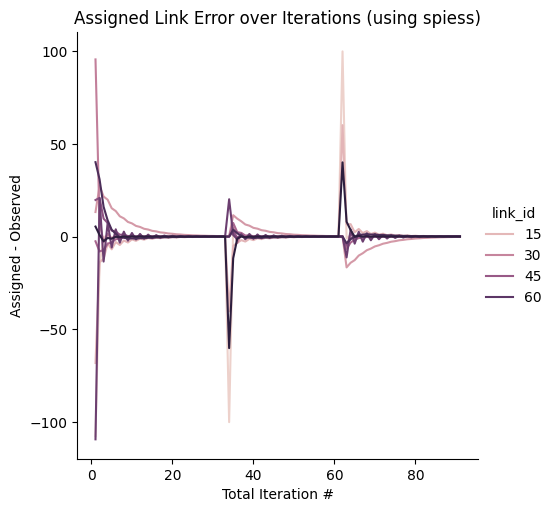

In [38]:
sns.relplot(x='Total Iteration #',
    y='Assigned - Observed',
    hue='link_id', 
    kind='line', 
    data=stats_spiess, 
    markers=True, 
    dashes=False)
plt.title(f"Assigned Link Error over Iterations (using {algorithm})")

plt.savefig(f"odme_plot/link_err_{algorithm}.png")

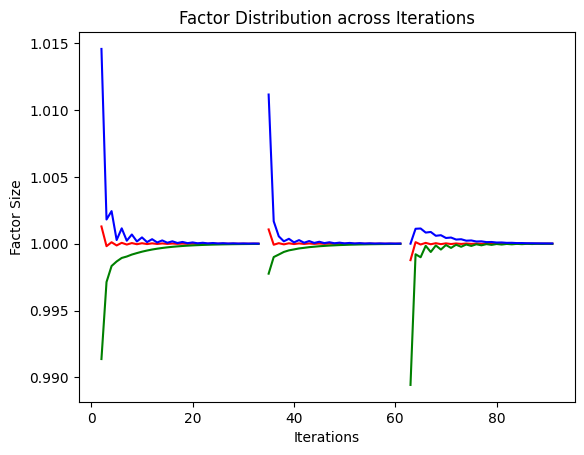

In [39]:
plt.plot(iter_spiess['Total Iteration #'], iter_spiess['mean_factor'], color="red")
plt.plot(iter_spiess['Total Iteration #'], iter_spiess['min_factor'], color="green")
plt.plot(iter_spiess['Total Iteration #'], iter_spiess['max_factor'], color="blue")

plt.xlabel("Iterations")
plt.ylabel("Factor Size")
plt.title("Factor Distribution across Iterations")

plt.savefig(f"odme_plot/factor_iter_{algorithm}.png")

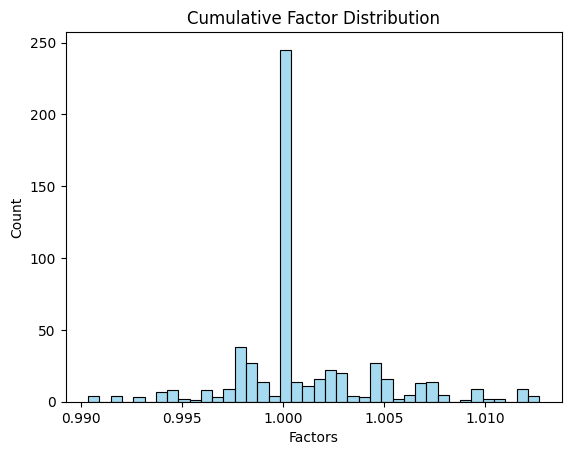

In [40]:
sns.histplot(cumulative_spiess['Factors'], bins=40, kde=False, color='skyblue')
plt.title("Cumulative Factor Distribution")

plt.savefig(f"odme_plot/cum_factor_{algorithm}.png")